# Building a school expenditure dashboard using widgets

In this notebook, we build a school expenditure dashboard using ipywidgets.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
import re
from IPython.display import display, clear_output
%matplotlib inline

In [4]:
all_years_data={}
for year in range(2006, 2013):
    all_years_data[year] = pd.read_csv('../../data/merged_data/expenditure_demo_account_year_{}.csv'.format(year), index_col=0)

Now that we've read in the data, we implement our UI for searching.

In [60]:
def search_function(Search):
    
    Search = Search.value
    
    ## Get school_names
    unique_schools = []
    for year in all_years_data:
        all_years_data[year].Name = all_years_data[year].Name.map(lambda x: str(x).strip()) #strip whitespace
        all_years_data[year].Name = all_years_data[year].Name.map(lambda x: re.sub('[^a-zA-Z0-9\s]','',x)) #strip non alphanumeric characters
        all_years_data[year].Name = all_years_data[year].Name.map(lambda x: str(x).upper()) #make uppercase
        unique_schools.extend(list(all_years_data[year].Name))
    unique_schools = list(set(unique_schools))
    
    ## Search through school names
    upper_school = re.sub('[^0-9a-zA-Z\s]', '', Search).upper()
    matches = [re.search(upper_school, name) for name in unique_schools]
    matching_schools = [i.string for i in matches if i != None]
    if len(matching_schools)<20:
        return matching_schools
    else:
        print '{} results found- here are 20 results. Re-search using more specific search terms.'.format(len(matching_schools))
        return matching_schools[0:30]

def plot_school(school):
    fig = plt.figure(figsize=(16,12))
    total_per_student = {}
    mean_by_T1_status = {}
    title_1 = {'Title 1':[],'non-Title 1':[]}
    for year in all_years_data:
        
        #Get group mean for comparison
        if all_years_data[year].loc[all_years_data[year]['Name'] == school,'Title_1'].isin([1]).values:
            title_1['Title 1'].append(year)
            mean_by_T1_status[year] = all_years_data[year].loc[all_years_data[year]['Title_1'] == 1,'Total'].mean()
        elif all_years_data[year].loc[all_years_data[year]['Name'] == school,'Title_1'].isin([0]).values:
            title_1['non-Title 1'].append(year)
            mean_by_T1_status[year] = all_years_data[year].loc[all_years_data[year]['Title_1'] == 0,'Total'].mean()
        
        #If school exists, get data for year
        if len(all_years_data[year].loc[all_years_data[year]['Name'] == school,'Total'])>0:
            total_per_student[year] = all_years_data[year].loc[all_years_data[year]['Name'] == school,'Total']
    
    mean_by_T1_status = pd.DataFrame.from_dict(mean_by_T1_status, orient='index')
    mean_by_T1_status.sort(inplace=True)
    total_per_student = pd.DataFrame.from_dict(total_per_student, orient='index')
    total_per_student.sort(inplace=True)
    
    
    ##Ax one- total expenditure comparison
    ax1 = plt.subplot(3,1,1)
    ax1.plot(total_per_student.index, total_per_student.values, marker='s', markersize=10, label='Expenditures per student at {}'.format(school.title()))
    
    #Make label for comparison plot:
    if len(title_1['Title 1']) == 0:
        comparison_label = 'Average expenditures across all non-Title 1 schools citywide'
    elif len(title_1['non-Title 1']) == 0:
        comparison_label = 'Average expenditures across all Title 1 schools citywide'
    else: ##Need to specify years for comparison
        comparison_label = 'Average expenditures across Title 1 schools (years {})\nand non-Title 1 schools (years {})'.format(str(title_1['Title 1']).strip('[]'),str(title_1['non-Title 1']).strip('[]'))
    
    ax1.plot(mean_by_T1_status.index, mean_by_T1_status.values, marker='o', markersize=10, label=comparison_label)
    title = 'Total expenditures per student by year'
    ax1.set_title(title)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total expenditures per student ($)')
    ax1.set_xlim((2006,2012))
    min_val = min(mean_by_T1_status.values.min(), total_per_student.values.min())-2000
    max_val = max(mean_by_T1_status.values.max(), total_per_student.values.max())+1000
    ax1.set_ylim((min_val,max_val))
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc='lower center', fancybox=True, shadow=True, ncol=2, fontsize='medium')
    
    DBN = []
    for year in all_years_data:
        DBN.extend(all_years_data[year].loc[all_years_data[year]['Name'] == school,'School'])
    if len(list(set(DBN))):
        make_all_subs(list(set(DBN))[0])
    else:
        make_all_subs(pd.Series(make_all_subs).value_counts().idxmax())
    plt.show()
    return 

def update_dropdown(search):
    global container
    clear_output()
    schools = search_function(search)
    if len(schools)>1:
        plot_school(schools[0])
        select_from = interactive(plot_school, school=widgets.Dropdown(options = schools, description = 'Select school to plot: '))
        container.children=[Search,select_from]
    if len(schools)==1:
        plot_school(schools[0])
        select_from = interactive(plot_school, school=widgets.Dropdown(options = schools, description = 'Select school to plot: '))
        container.children=[Search,select_from]
    if len(schools)==0:
        print '{} not found- please search for a different school'.format(Search.value)
        select_from = interactive(plot_school, school=widgets.Dropdown(options = schools, description = 'Select school to plot: '))
        container.children=[Search,select_from]

In [266]:
import matplotlib.patches as mpatches

def make_sub_plot(year, DBN):
    matches = [re.search(r'_All_Funds', x) for x in list(all_years_data[year].columns)]
    matches = [x for x in matches if x is not None]
    matches = [x.string for x in matches]

    matches_keys = [' '.join(re.findall('[A-Z][^A-Z]*', x)) for x in matches]
    matches_keys = [re.sub('_',' ', x) for x in matches_keys]
    matches_keys = [re.sub('  ', ' ', x) for x in matches_keys]
    matches_keys = [re.sub('Srcs', 'Services', x) for x in matches_keys]
    matches_keys = [re.sub(' All Funds', '', x) for x in matches_keys]
    map_cols_to_keys = dict(zip(matches, matches_keys))
    
    possible_categories = ['Instructional Support Services', 'Central Instructional Support',
                           'Central Administration', 'Leadership Supervision Support',
                           'Ancillary Support Services', 'Building Services', 'Regional Support',
                           'Classroom Instruction', 'Instructional Support and Administration',
                           'Other Regional Costs', 'Referral and Evaluation Services',
                           'Field Support', 'Instructional Support Services', 'Other Field Support Costs',]
    
    color_scale = [plt.get_cmap('Set1')(i) for i in np.linspace(0, 1, len(possible_categories))]
    map_keys_to_colors = dict(zip(possible_categories,color_scale))
    xtick_labels = dict(zip(possible_categories, range(len(possible_categories))))

    #School data
    target_school = all_years_data[year].loc[DBN, matches]
    target_school.index = [map_cols_to_keys[x] for x in target_school.index]
    target_school.sort(inplace=True, ascending=False)
    target_school = target_school/target_school.sum()
    target_school.name = ''
    school_colors=[map_keys_to_colors[x] for x in target_school.index]
    handles = [mpatches.Patch(color=map_keys_to_colors[x], label=str(x)) for x in list(target_school.index)]
    
    #Comparison data
    compare_groups = all_years_data[year].groupby('Title_1')
    mean_expenditures = compare_groups.get_group(all_years_data[year].loc[DBN,'Title_1'])[matches].mean()
    mean_expenditures.index = [map_cols_to_keys[x] for x in mean_expenditures.index]
    mean_expenditures.sort(inplace=True, ascending=False)
    mean_expenditures = mean_expenditures/mean_expenditures.sum()
    mean_expenditures.name = ''
    compare_colors=[map_keys_to_colors[x] for x in mean_expenditures.index]
    handles.extend([mpatches.Patch(color=map_keys_to_colors[x], label=str(x)) for x in list(mean_expenditures.index)])
    
    xs_for_bar = dict(zip(possible_categories, range(1, len(possible_categories)+1)))
    ax = plt.gca()
    ax.set_axisbelow(True)
    plt.grid(color='k', axis='y', linestyle='-', linewidth=0.5)
    school = plt.bar([xs_for_bar[x] for x in target_school.index], target_school.values, width=0.4, color=school_colors)
    compare = plt.bar([xs_for_bar[x] + 0.4 for x in mean_expenditures.index], mean_expenditures.values, width=0.4,  color=compare_colors)
    for bar in compare:
        bar.set_hatch('//')
    plt.xticks([],[])
    return (handles, school, compare)

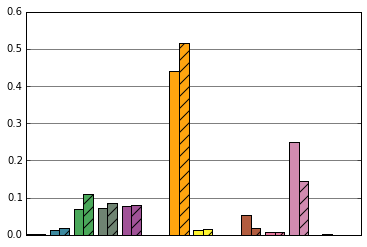

In [267]:
handles, school, compare = make_sub_plot(2009, 'M015')

In [268]:
def make_all_subs(DBN):
    handles = []
    handle_labels = []
    for year in range(2006,2010):
        ax = plt.subplot(3,4, year-2001)
        ax.set_title(str(year))
        try:
            handle_for_school, school, compare = make_sub_plot(year, DBN)
            if year == 2006:
                plt.ylabel('Percent of Total Expenditures')
            handles.extend(handle_for_school)
        except KeyError: ##School not in dataset for year
            ax.axis('off')
            ax.text(0.5, 0.5,'Data not available\nfor {}'.format(str(year)), fontsize=16,
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            
    for year in range(2010, 2013):
        ax = plt.subplot(3,4, year-2001)
        ax.set_title(str(year))
        try:
            handle_for_school, school, compare = make_sub_plot(year, DBN)
            if year == 2010:
                plt.ylabel('Percent of Total Expenditures')
            handles.extend(handle_for_school)
        except KeyError: ##School not in dataset for year
            ax.axis('off')
            ax.text(0.5, 0.5,'Data not available\nfor {}'.format(str(year)), fontsize=16,
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    legend_corner = plt.subplot(3,4,12)
    legend_corner.axis('off')
    unique_handles = []
    for patch in handles:
        if patch.get_label() in handle_labels:
            pass
        else:
            handle_labels.append(patch.get_label())
            unique_handles.append(patch)
    plt.legend(handles=unique_handles, fontsize='medium', loc='center', title='Legend')

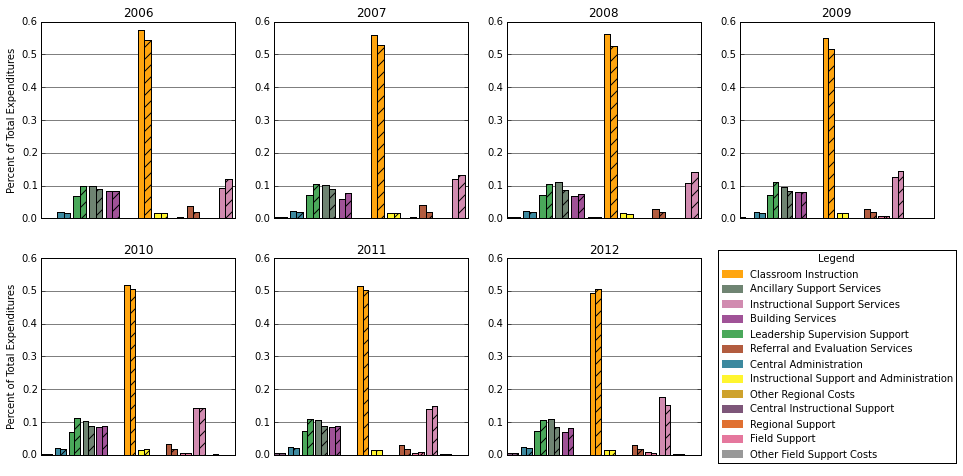

In [269]:
plt.figure(figsize=(16,12))
make_all_subs('K100')

Now let's test it out:

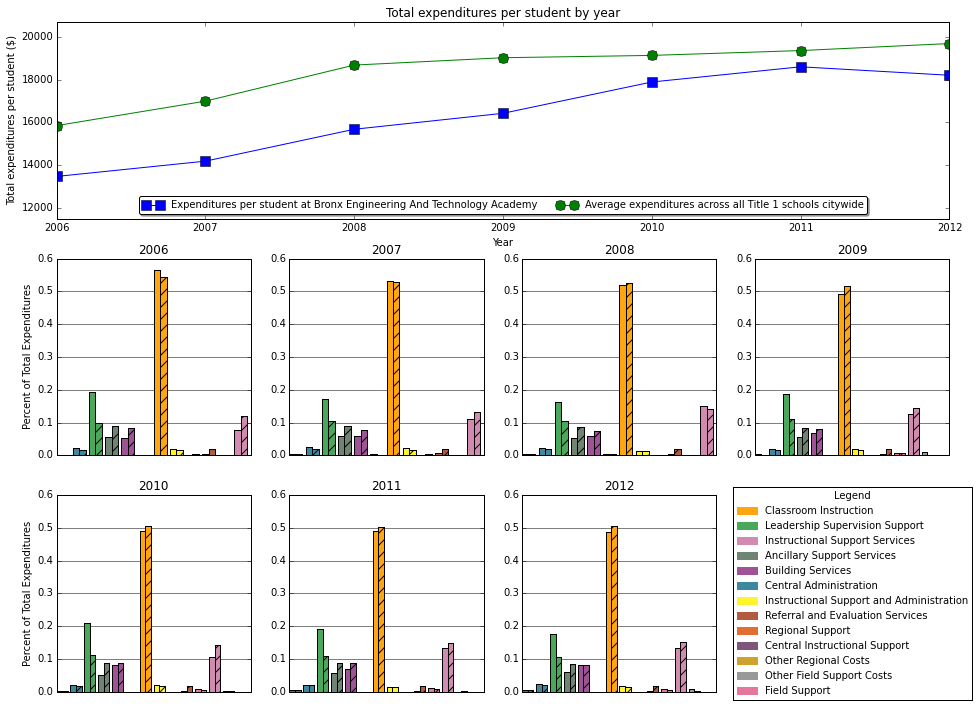

In [270]:
container = widgets.Box()
container.border_color = 'red'
container.border_style = 'dotted'
container.border_width = 3
Search = widgets.Text(description='Search:', value='Bronx Lab')
container.children=[Search]
display(container)
Search.on_submit(update_dropdown)